## Descriptive: What is happening?

## Diagnostic: Why is it happening?

In [1]:
import pandas as pd

## Load data from excel file

In [2]:
df = pd.read_excel('../data/Production Data Versaline.xlsx')
df = df.rename(columns={"Breakdowns and other delays": "BD & other", "Effective production time": "Eff Prod time"})
print(df.columns)
df.head(2)

Index(['Date', 'Product', 'Planned start Time', 'Actual Start Time',
       'Stop Time', 'Total time', 'Startup Delay', 'BD & other',
       'Eff Prod time', 'Operating Speed', 'Produced Qty', 'Rejects Qty',
       'Mix Usage', 'Mix Wastage', 'Mix yield', 'AR', 'PR', 'QR', 'OEE',
       'Mix Per Stick', 'Efficiency', 'Planned Qty'],
      dtype='object')


,Date,Product,Planned start Time,Actual Start Time,Stop Time,Total time,Startup Delay,BD & other,Eff Prod time,Operating Speed,...,Mix Usage,Mix Wastage,Mix yield,AR,PR,QR,OEE,Mix Per Stick,Efficiency,Planned Qty
0,2018-07-02,WB Chocolate,06:30:00,10:30:00,20:30:00,14.0,4.0,5.15,4.85,28880,...,7840.0,991.000,0.873597,0.346429,1.496754,0.873597,0.452976,0.0375,0.499675,NaN
1,2018-07-04,WB Vanilla,06:00:00,18:30:00,20:00:00,14.0,12.5,0.00,1.50,28880,...,1160.0,40.625,0.964978,0.107143,0.716049,0.964978,0.074033,0.0375,0.098710,NaN


### Calculate Rejects percentage and add as a colomn

Rejects percentage = Rejects Qty / Total Qty

## Fill the NAN values with the mean of the colomn

In [3]:
for val in ["Mix yield", "Rejects Qty"]:
    df[val] = df[val].fillna(df[val].mean())
df = df.drop(['Planned Qty'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                441 non-null    datetime64[ns]
 1   Product             441 non-null    object        
 2   Planned start Time  441 non-null    object        
 3   Actual Start Time   441 non-null    object        
 4   Stop Time           441 non-null    object        
 5   Total time          441 non-null    float64       
 6   Startup Delay       441 non-null    float64       
 7   BD & other          441 non-null    float64       
 8   Eff Prod time       441 non-null    float64       
 9   Operating Speed     441 non-null    int64         
 10  Produced Qty        441 non-null    int64         
 11  Rejects Qty         441 non-null    float64       
 12  Mix Usage           441 non-null    float64       
 13  Mix Wastage         441 non-null    float64       

In [4]:
# Add rejects percentage
def get_rejects_percentage(row):
    return row["Rejects Qty"]/row["Produced Qty"]

df['Rejects Pct'] = df.apply (lambda row: get_rejects_percentage(row), axis=1)
# df.info()

## Select only the useful features
remove duplicate features such as start time and end time

In [5]:
useful_colomns = ["Product", "Startup Delay", "BD & other", "Eff Prod time", "Rejects Pct", "Mix Usage", "Mix Wastage", "Mix yield", "OEE"]
df_use = df[useful_colomns]

df_use.head(2)

,Product,Startup Delay,BD & other,Eff Prod time,Rejects Pct,Mix Usage,Mix Wastage,Mix yield,OEE
0,WB Chocolate,4.0,5.15,4.85,0.144693,7840.0,991.000,0.873597,0.452976
1,WB Vanilla,12.5,0.00,1.50,0.036293,1160.0,40.625,0.964978,0.074033


In [6]:
df.Product.unique()

array(['WB Chocolate', 'WB Vanilla', 'JJ Necto', 'MM Watermelon',
       'MM Orange', 'WB Chock Shock', 'WB Berry', '2-Bar Vanilla Faluda',
       'JJ Cream Soda', 'JJ Orange Crush ', 'Ice Cake', 'Bubble Gumy',
       'JJ Creamsoda', 'WB Vnilla', 'Bubble Gummy', 'Ice cake',
       'WB Chocok Shock', 'JJ Orange Crush'], dtype=object)

## Rename Duplicates products with the correct name

In [7]:
df = df.replace({'Product': {"JJ Orange Crush ": "JJ Orange Crush", 
                             "WB Chocok Shock": "WB Chock Shock",
                            "Ice cake": "Ice Cake",
                            "Bubble Gumy":"Bubble Gummy", 
                            "WB Vnilla": "WB Vanilla",
                            "JJ Creamsoda": "JJ Cream Soda"}})
for product in df.Product.unique():
    print("{:15} = {}".format(product, df[df["Product"] == product]["Product"].count()))

WB Chocolate    = 62
WB Vanilla      = 74
JJ Necto        = 45
MM Watermelon   = 51
MM Orange       = 65
WB Chock Shock  = 30
WB Berry        = 16
2-Bar Vanilla Faluda = 65
JJ Cream Soda   = 15
JJ Orange Crush = 8
Ice Cake        = 5
Bubble Gummy    = 5


In [8]:
print("Number of rows: {}".format(df.Product.count()))
df.info()

Number of rows: 441
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                441 non-null    datetime64[ns]
 1   Product             441 non-null    object        
 2   Planned start Time  441 non-null    object        
 3   Actual Start Time   441 non-null    object        
 4   Stop Time           441 non-null    object        
 5   Total time          441 non-null    float64       
 6   Startup Delay       441 non-null    float64       
 7   BD & other          441 non-null    float64       
 8   Eff Prod time       441 non-null    float64       
 9   Operating Speed     441 non-null    int64         
 10  Produced Qty        441 non-null    int64         
 11  Rejects Qty         441 non-null    float64       
 12  Mix Usage           441 non-null    float64       
 13  Mix Wastage         441 non-nu

In [9]:
group_by_products = df.groupby(by=['Product'])
product_data_avg = group_by_products.mean()
product_data_count = group_by_products.count()
# print(product_data_avg)
# print(product_data_count)

## Some plots using seaboarn
https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
    

### OEE vs Rejects Percentage

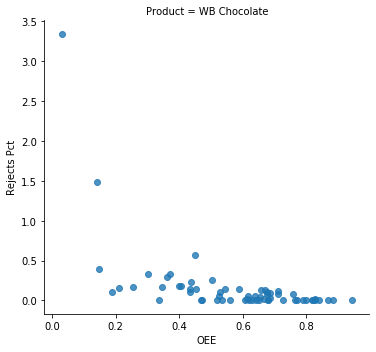

In [10]:
import seaborn as sns
%matplotlib inline

filtered_class = df[df['Product'] == 'WB Chocolate']
sns.lmplot("OEE", "Rejects Pct", data=filtered_class, fit_reg=False, col='Product', col_wrap=2)

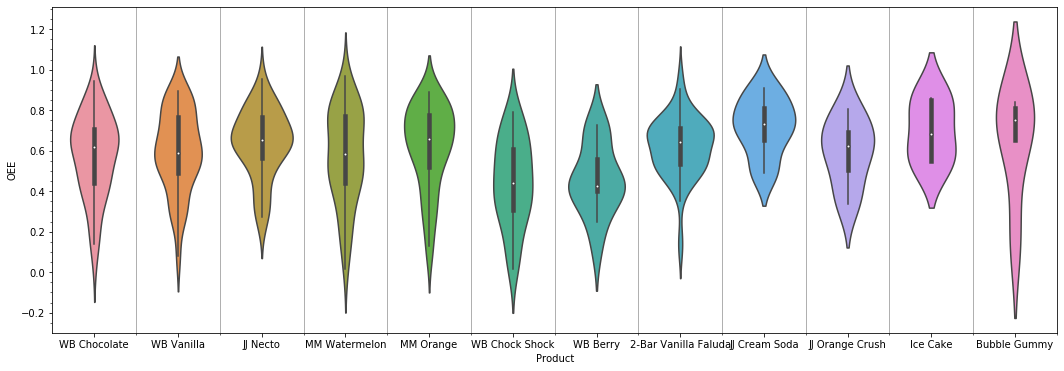

In [11]:
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,6))

ax1 = sns.violinplot('Product', "OEE", data=df)


ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

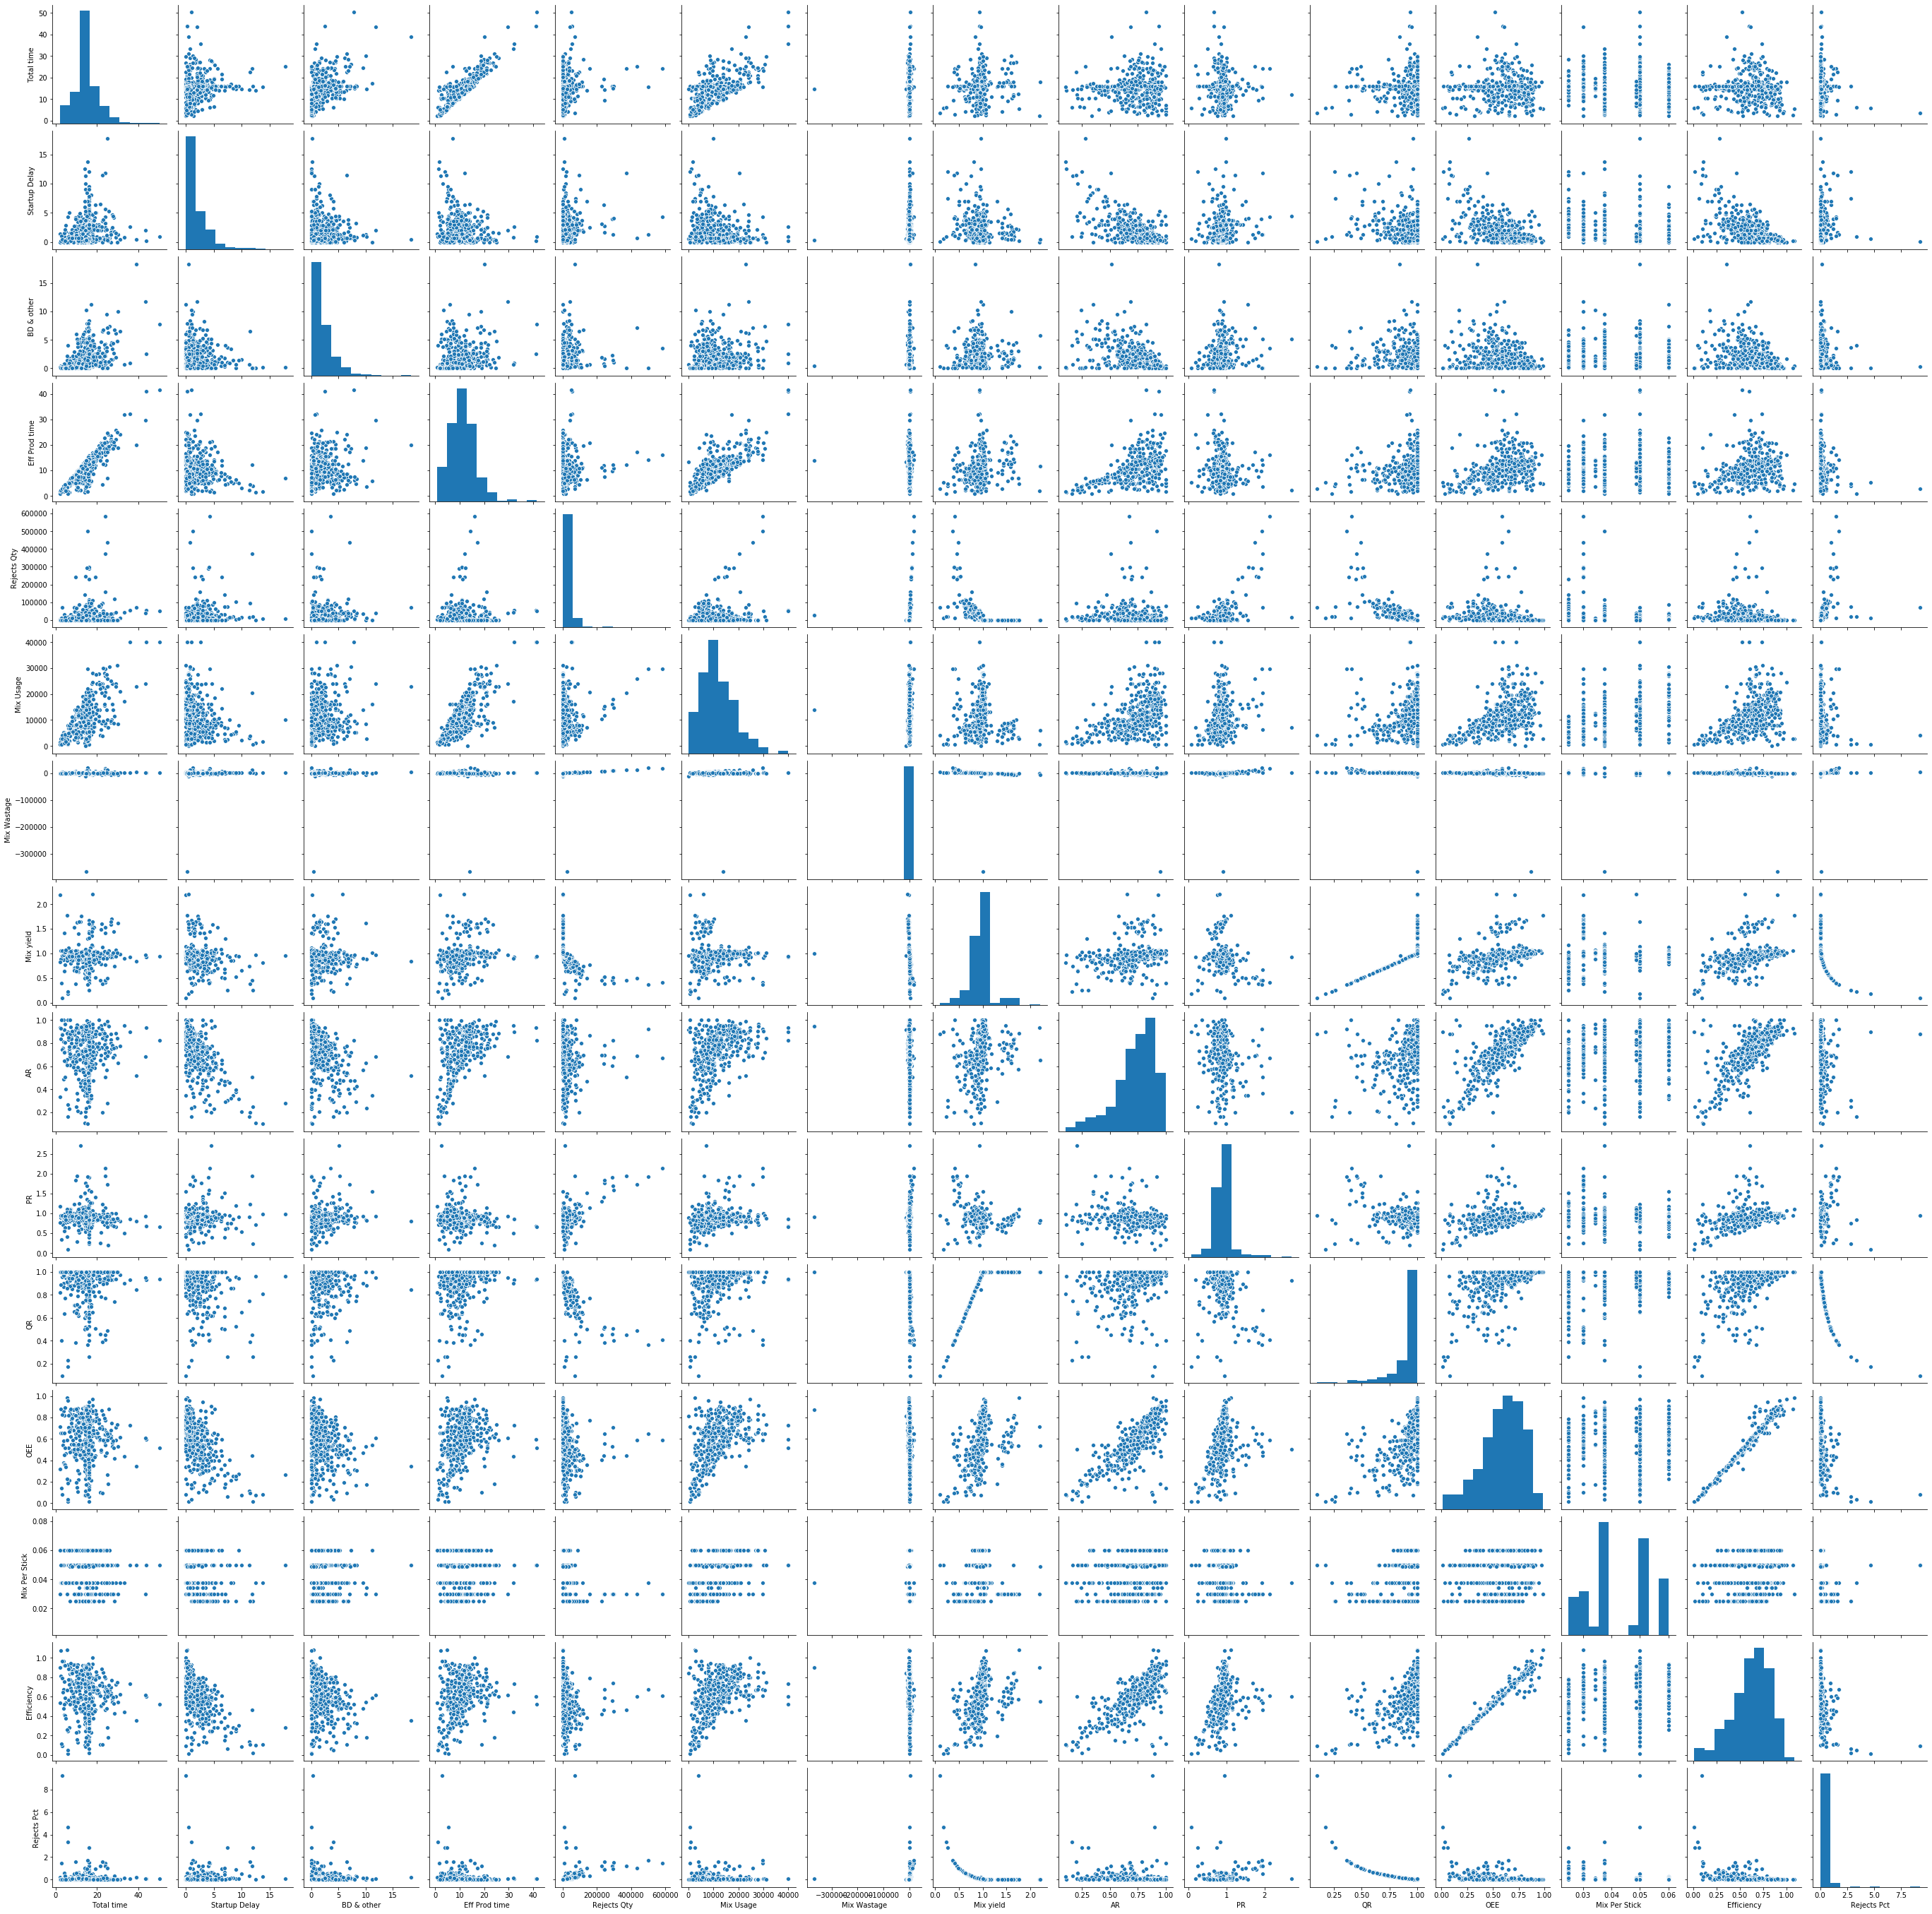

In [12]:
sns.pairplot(df.loc[:,df.dtypes == 'float64'])

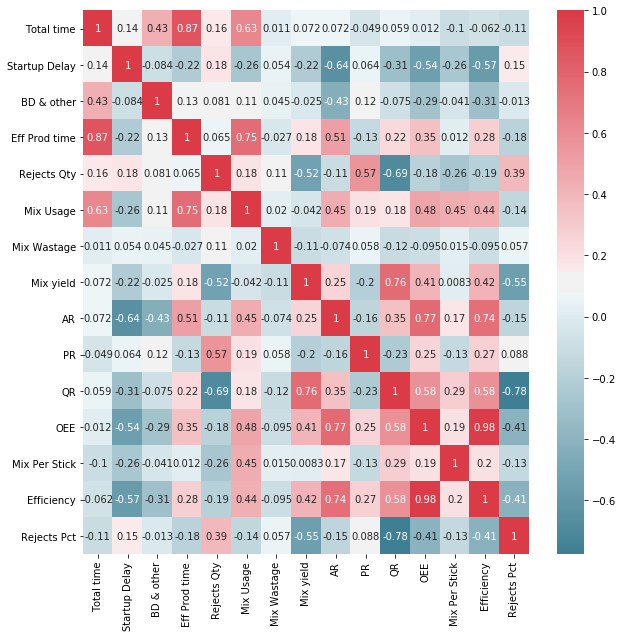

In [13]:
corr = df.loc[:,df.dtypes == 'float64'].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

In [14]:
for col in df.columns.values:
    print("{:20} = {}".format(col, df[col].nunique()))

Date                 = 390
Product              = 12
Planned start Time   = 151
Actual Start Time    = 224
Stop Time            = 218
Total time           = 208
Startup Delay        = 130
BD & other           = 261
Eff Prod time        = 386
Operating Speed      = 5
Produced Qty         = 433
Rejects Qty          = 297
Mix Usage            = 253
Mix Wastage          = 435
Mix yield            = 439
AR                   = 431
PR                   = 436
QR                   = 300
OEE                  = 439
Mix Per Stick        = 7
Efficiency           = 441
Rejects Pct          = 301


In [15]:
import numpy as np
print(np.min(df["Efficiency"]))
print(np.max(df["Efficiency"]))
print(np.average(df["Efficiency"]))
print(np.var(df["Efficiency"]))

0.0144463293667572
1.08422471300031
0.6174142201712173
0.041447896769146904


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81d427ae50>]],
      dtype=object)

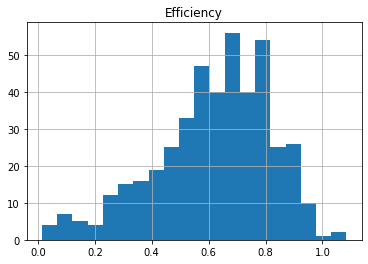

In [16]:
df.hist(bins=20, column="Efficiency")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81d22eb210>,
      dtype=object)

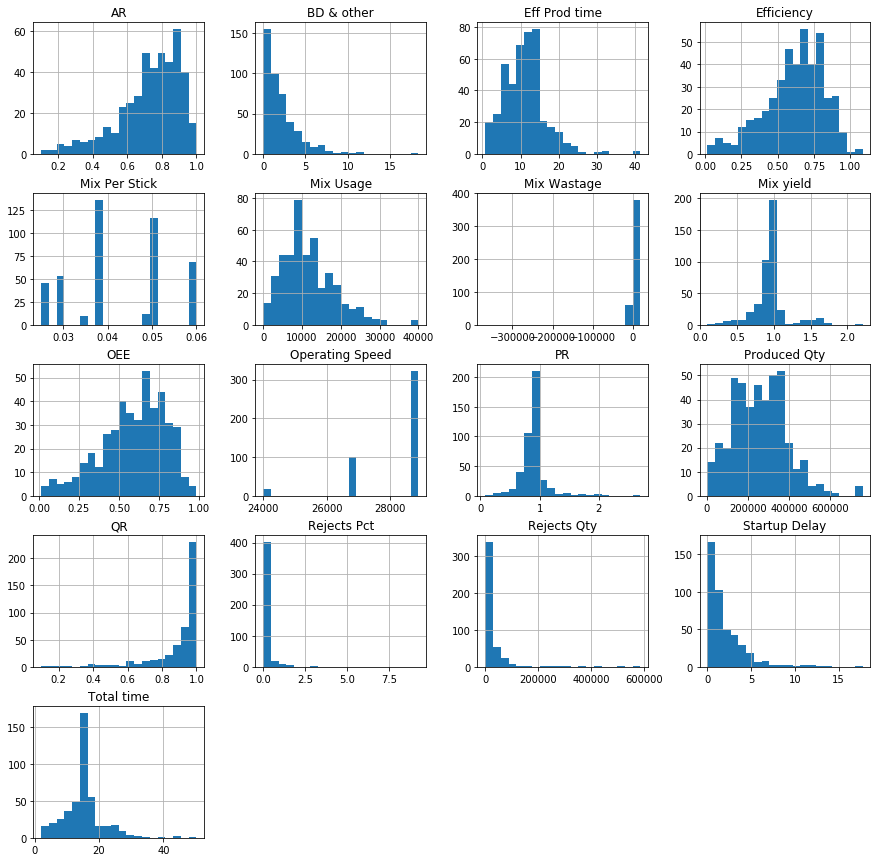

In [17]:
df.hist(bins=20, figsize=(15,15))